In [1]:
import tensorflow as tf


import cv2
import os
import matplotlib.pyplot as plt
import sys

import os.path as pth
from tqdm import tqdm
#import tqdm
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

# Tensorflow 관련 라이브러리
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, BatchNormalization, PReLU
from tensorflow.keras.layers import Flatten, Activation, Dense, GlobalAveragePooling2D, Softmax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# tensorflow에서 사용할 수 없는 기능을 구현하는 기여 저장소
from tensorflow_addons import optimizers

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=15000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
# 엑셀 1번 시트에 맞춰 라벨링

label_df = pd.read_excel('./data/categries_emo_new.xlsx')
label_dict = dict(label_df[['Num','Emotion']].values)


# 파일 제목에서 3번째 항목만 사용
print(label_df)

emotion_arr = label_df.loc[:,'Num'].values


emotion_list = emotion_arr.tolist()
#print(emotion_list)


# 리턴되는지 확인
label_dict[3]

   Num    Emotion
0    1      Happy
1    2        Sad
2    3      Angry
3    4    Fearful
4    5  Surprised


'Angry'

In [ ]:
#### 이미지 파일의 경로 + 라벨링 df 생성

files = list()
categories = list()

path = './data/ck_img/CK+48'


for img_cat in os.listdir(path):
    cat = path + '/' + img_cat
    
    for img_dir in os.listdir(cat):
        files.append(cat + '/' + img_dir)
        
# print(files)

for file_path in files:
    
    emo = file_path.split('/')[4]
    
    if emo == 'happy':
        categories.append('1')
        
    elif emo == 'sadness':
        categories.append('2')
        
    elif emo == 'anger':
        categories.append('3')
        
    elif emo == 'fear':
        categories.append('4')
        
    else:
        categories.append('5')
        
        
            
ck_train_data = pd.DataFrame({'file':files,
                              'label':categories})



label = ck_train_data.loc[:,'label'].values
emotion = list()

for n in label:
    emotion.append(label_dict[int(n)])
    
    
ck_train_data['emotion'] = emotion
ck_train_data




In [ ]:
grouped_re = ck_train_data['file'].groupby(ck_train_data['emotion'])

# print(grouped_cro)

grouped_re.size()

In [3]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _validate_text(text):
    """If text is not str or unicode, then try to convert it to str."""
    if isinstance(text, str):
        return text
    elif isinstance(text, 'unicode'):
        return text.encode('utf8', 'ignore')
    else:
        return str(text)

In [ ]:
def to_tfrecords(id_list, emotion_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, emotion_id in tqdm(zip(id_list, emotion_list), total=len(id_list), position=0, leave=True):
            image_path = pth.join(id_) # 불러올 이미지 위치 입력
            _binary_image = tf.io.read_file(image_path)
            
            # 타입 변환 함수 넣어서 타입 맞추기    
            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'img_id': _bytes_feature(emotion_id.encode()),
                'id': _bytes_feature(_validate_text(id_).encode()),
            }))

            writer.write(string_set.SerializeToString())   

In [ ]:
# train, valid set 나누기
with tf.device('/device:GPU:0'):
    train_ids, val_ids, train_emotion_ids, val_emotion_ids = train_test_split(ck_train_data['file'], ck_train_data['label'], test_size=0.2, random_state=42, shuffle=True,
                                                                              stratify=ck_train_data['label'])
# 파일이 생성될 위치 지정
    to_tfrecords(train_ids, train_emotion_ids, pth.join('./data/ck_tf', 'tf_record_train_5'))
    to_tfrecords(val_ids, val_emotion_ids, pth.join('./data/ck_tf', 'tf_record_valid_5'))

In [4]:
train_tfrecord_path = pth.join('./data/ck_tf', 'tf_record_train_5.tfrecords')
valid_tfrecord_path = pth.join('./data/ck_tf', 'tf_record_valid_5.tfrecords')

BUFFER_SIZE = 48
BATCH_SIZE = 64
NUM_CLASS = 5

In [ ]:
# one-hot encoding test

listTemp=[1,2,3,4,5]
for n in listTemp:
    test = tf.one_hot(n, depth=NUM_CLASS)
    print("{}".format(n))
    print(test)
    



In [5]:
with tf.device('/device:GPU:0'):
    image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'img_id': tf.io.FixedLenFeature([], tf.string),
        # 'id': tf.io.FixedLenFeature([], tf.string),
    }



    def _parse_image_function(example_proto):
        return tf.io.parse_single_example(example_proto, image_feature_description)

    def map_func(target_record):
        
        img = target_record['image_raw']
        label = int(target_record['img_id'])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.dtypes.cast(img, tf.float32)
        return img, label

    def prep_func(image, label):
        print(type(label))
            
        result_image = image / 255
        result_image = tf.image.resize(result_image, (48,48))
        
        onehot_label = tf.one_hot(label, depth=NUM_CLASS)
        return result_image, onehot_label

    
with tf.device('/device:GPU:0'):
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    valid_dataset = tf.data.TFRecordDataset(valid_tfrecord_path, compression_type='GZIP')
    valid_dataset = valid_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.shuffle(BUFFER_SIZE)
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    valid_dataset = valid_dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


(64, 48, 48, 3) (64, 5)
[0. 0. 0. 0. 1.]
Fearful


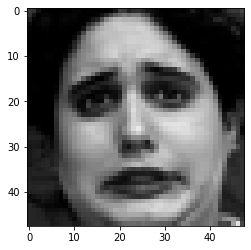

In [7]:
for batch_x, batch_y in dataset:
    print(batch_x.shape, batch_y.shape)
    print(batch_y[0].numpy())

    target_class = np.argmax(batch_y[0].numpy())
    
    if target_class == 0:
        target_class = 5
        
    
    print(label_dict[target_class])
    
#     if target_class==1:
#         plt.figure()
#         plt.imshow(batch_x[0].numpy())
#         plt.show()
#         break
        
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    plt.show()
    
    break

(64, 48, 48, 3) (64, 5)
Surprised


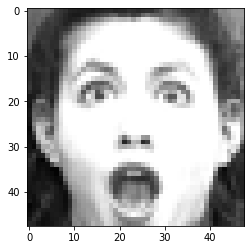

In [8]:
for batch_x, batch_y in valid_dataset:
    print(batch_x.shape, batch_y.shape)
    
    target_class = np.argmax(batch_y[0].numpy())
    #print(target_class)
    
    if target_class == 0:
        target_class = 5
    
    print(label_dict[target_class])
    
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    plt.show()
    
    break

In [9]:
earlystop = EarlyStopping(patience = 5)

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 2,
                                            factor = 0.5,
                                            min_lr = 1e-7,
                                            verbose = 1)

model_check = ModelCheckpoint(filepath = './model/ck5_facial_cnn_48_48_ReLU.h5',
                              monitor = 'val_loss',
                              save_best_only = True)

callbacks = [earlystop, learning_rate_reduction, model_check]

In [13]:
input_shape=(48,48,3)

model = Sequential()
model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobilenet = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (48,48,3))


for layer in mobilenet.layers:
    layer.trainable = True
    
for (i, layer) in enumerate(mobilenet.layers):
    print(str(i), layer.__class__.__name__, layer.trainable)
    
    
model = Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Dense(5))
model.add(BatchNormalization())
model.add(PReLU())
model.add(Softmax(dtype='float32', name='softmax'))
model.summary()

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RectifiedAdam(learning_rate=0.001),
              metrics=['accuracy'])

In [15]:
history = model.fit(dataset,
                    epochs=100,
                    validation_data=valid_dataset,
                    callbacks=callbacks,
                   )

Epoch 1/100
10/10 [==============================] - 0s 38ms/step - loss: 1.0769 - accuracy: 0.2150 - val_loss: 1.0676 - val_accuracy: 0.1667
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0619 - accuracy: 0.2217 - val_loss: 1.0477 - val_accuracy: 0.2733
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 1.0372 - accuracy: 0.2750 - val_loss: 1.0186 - val_accuracy: 0.2733
Epoch 4/100
 8/10 [=======================>......] - ETA: 0s - loss: 1.0018 - accuracy: 0.2598
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 [==============================] - 0s 15ms/step - loss: 1.0002 - accuracy: 0.2750 - val_loss: 0.9617 - val_accuracy: 0.2733
Epoch 5/100
10/10 [==============================] - 0s 16ms/step - loss: 0.9530 - accuracy: 0.2750 - val_loss: 0.9271 - val_accuracy: 0.2733
Epoch 6/100
 7/10 [====================>.........] - ETA: 0s - loss: 0.9568 - accuracy: 0.2478
Epoch 00006: ReduceLROnPlateau r